In [19]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

import keras_tuner as kt

from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout

from sklearn.model_selection import train_test_split

In [20]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.8)

X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0

# EDA

In [21]:
import seaborn as sns
pd.value_counts(y_valid.flatten()) / len(y_valid.flatten())

1    0.1058
3    0.1015
7    0.1012
5    0.1009
6    0.1001
9    0.0998
4    0.0997
2    0.0988
8    0.0965
0    0.0957
dtype: float64

In [22]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

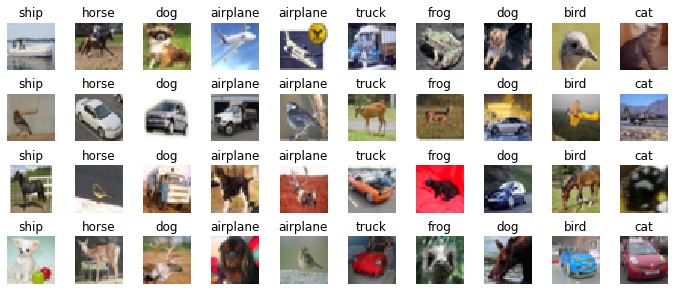

In [23]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train.flatten()[index%10]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
# plt.save_fig('digits_mnist_plot', tight_layout=False)
plt.show()

# 8 - Train a DNN on the CIFAR10 dataset

## 8.b- DNN, 20 layers, 100 neurons, He initialization, ELU

In [6]:
log_dir = './tensorboard-logs/image-classifier-cifar10-dataset/chapter-11-8a-lr-nadam'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [73]:
# setup LR scheduler
# initial_learning_rate * decay_rate ^ (step / decay_steps)
schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.1, 
    decay_steps = 5, 
    decay_rate = 0.5, 
    staircase=True # staircase function, 
)
lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=1)

In [74]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3])) # same as InputLayer
for layer in range(20):
    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer='he_normal'))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

In [75]:
# setup optimizer
# optimizer = keras.optimizers.SGD(momentum=0.8)
# optimizer = keras.optimizers.Adam(learning_rate=0.001)
optimizer = keras.optimizers.Nadam(learning_rate=1e-5)

# compile
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)

In [76]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, tensorboard_cb, lr_scheduler],
)


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/50
1250/1250 [==============================] - 24s 15ms/step - loss: 11278338048.0000 - accuracy: 0.1009 - val_loss: 9.1141 - val_accuracy: 0.1032 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 2/50
1250/1250 [==============================] - 21s 17ms/step - loss: 4.6497 - accuracy: 0.1004 - val_loss: 5.0133 - val_accuracy: 0.0969 - lr: 0.1000

Epoch 3: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 3/50
1250/1250 [==============================] - 15s 12ms/step - loss: 76.7076 - accuracy: 0.1003 - val_loss: 2.8532 - val_accuracy: 0.1032 - lr: 0.1000

Epoch 4: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 4/50
1250/1250 [==============================] - 15s 12ms/step - loss: 3.5214 - accuracy: 0.0974 - val_loss: 4.4451 - val_accuracy: 0.1037 - lr: 0.1000

Epoch 5: LearningRateScheduler setting l

KeyboardInterrupt: 

### Find optimal learning rate

In [50]:
log_dir = './tensorboard-logs/image-classifier-cifar10-dataset/lr-optimizer'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# setup LR scheduler
# initial_learning_rate * decay_rate ^ (step / decay_steps)
schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 1e-6, 
    decay_steps = 1, 
    decay_rate = 2, 
    staircase=True
)
lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=1)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3])) # same as InputLayer
# model.add(keras.layers.BatchNormalization())
for layer in range(20):
    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer='he_normal'))
#     model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

# setup optimizer
optimizer = keras.optimizers.Nadam()

# compile
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)

history = model.fit(
    X_train, 
    y_train, 
    epochs=16, 
    validation_data=(X_valid, y_valid),
    callbacks=[tensorboard_cb, lr_scheduler],
)


Epoch 1: LearningRateScheduler setting learning rate to 9.999999974752427e-07.
Epoch 1/16
1250/1250 [==============================] - 25s 15ms/step - loss: 2.4861 - accuracy: 0.1454 - val_loss: 2.2745 - val_accuracy: 0.1725 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999949504854e-06.
Epoch 2/16
1250/1250 [==============================] - 16s 13ms/step - loss: 2.1508 - accuracy: 0.2116 - val_loss: 2.0698 - val_accuracy: 0.2389 - lr: 2.0000e-06

Epoch 3: LearningRateScheduler setting learning rate to 3.999999989900971e-06.
Epoch 3/16
1250/1250 [==============================] - 17s 14ms/step - loss: 2.0033 - accuracy: 0.2702 - val_loss: 1.9575 - val_accuracy: 0.2930 - lr: 4.0000e-06

Epoch 4: LearningRateScheduler setting learning rate to 7.999999979801942e-06.
Epoch 4/16
1250/1250 [==============================] - 17s 13ms/step - loss: 1.9048 - accuracy: 0.3164 - val_loss: 1.8697 - val_accuracy: 0.3250 - lr: 8.0000e-06

Epoch 5: LearningRateSched

Text(0, 0.5, 'Loss')

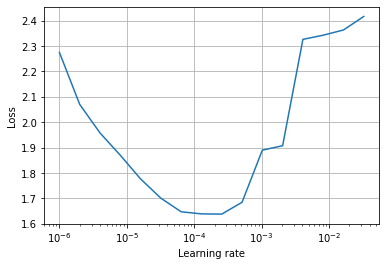

In [51]:
plt.plot(history.history['lr'], history.history['val_loss'])
plt.gca().set_xscale('log')
# plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
# plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [52]:
history.history['lr']

[1e-06,
 2e-06,
 4e-06,
 8e-06,
 1.6e-05,
 3.2e-05,
 6.4e-05,
 0.000128,
 0.000256,
 0.000512,
 0.001024,
 0.002048,
 0.004096,
 0.008192,
 0.016384,
 0.032768]

In [54]:
optimal_rate = 2.5e-4 #0.000256

### Use optimal rate

In [ ]:
log_dir = './tensorboard-logs/image-classifier-cifar10-dataset/optimal-rate'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

# create model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3])) # same as InputLayer
for layer in range(20):
    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer='he_normal'))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

# setup optimizer
optimizer = keras.optimizers.Nadam(learning_rate=optimal_rate)

# compile
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)

# train
history = model.fit(
    X_train, 
    y_train, 
    epochs=13, 
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, tensorboard_cb],
)

Epoch 1/13


## 8.c - Batch Normalization

In [ ]:
log_dir = './tensorboard-logs/image-classifier-cifar10-dataset/optimal-rate'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

# create model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3])) # same as InputLayer
model.add(keras.layers.BatchNormalization())
for layer in range(20):
    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer='he_normal'))
    model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

# setup optimizer
optimizer = keras.optimizers.Nadam(learning_rate=optimal_rate)

# compile
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)

# train
history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, tensorboard_cb],
)

## 8.d - SELU activation

In [ ]:
log_dir = './tensorboard-logs/image-classifier-cifar10-dataset/optimal-rate'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir)

# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

# create model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3])) # same as InputLayer
model.add(keras.layers.Normalization())
for layer in range(20):
    model.add(keras.layers.Dense(100, activation="selu", kernel_initializer='lecun_normal'))
model.add(keras.layers.Dense(10, activation="softmax")) # softmax activation layer because the classes are exclusive, otherwise sigmoid would work

# setup optimizer
optimizer = keras.optimizers.Nadam(learning_rate=optimal_rate)

# compile
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
)

# train
history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, tensorboard_cb],
)